# Creating dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
DATADIR = '../datasets/Classification/Dataset - 3 dias/Images'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [3]:
def create_training_data():
    training_data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            ## add images to training data with its label
            training_data.append([img_array, class_num])
    return training_data
            
training_data = create_training_data()
            

In [4]:
print(len(training_data))

1101


In [5]:
#mix data for better learning
import random
random.shuffle(training_data)

In [6]:
images = []
labels = []

for image, label in training_data:
    images.append(image)
    labels.append(label)

In [7]:
##saving dataset
import pickle
DATASET_PATH = "../datasets/Classification/Dataset - 3 dias/"

pickle_out = open(os.path.join(DATASET_PATH, "3_days_images.pickle"), "wb")
pickle.dump(images, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(DATASET_PATH, "3_days_labels.pickle"), "wb")
pickle.dump(labels, pickle_out)
pickle_out.close()



# Creating classification model
##### Following this tutorial
       www.youtube.com/watch?v=WvoLTXIjBYU
##### Characteristics
 - Sequencial Model
 - Fully trained on this dataset

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os


#### Reading and preparing the dataset

In [9]:
import imutils
def pad_image(image, size_x, size_y):
    shape = image.shape
    res = []
    
    pad_image = np.zeros((size_x,size_y,3), np.uint8)
    
    if shape[0] > shape[1]:
        res = imutils.resize(image, height=size_x)
        res = center_image(res, pad_image)
    else:
        res = imutils.resize(image, width=size_y)
        res = center_image(res, pad_image)
    
    return res
    
def center_image(image, background):
    img_shape = image.shape
    bck_shape = background.shape
    
    x_diff = round((bck_shape[0] - img_shape[0])/2)
    y_diff = round((bck_shape[1] - img_shape[1])/2)
    
#     print(image.shape, background.shape, x_diff, y_diff)
    
    res = background.copy()
    
    res[x_diff:x_diff + img_shape[0],y_diff:y_diff + img_shape[1]] = image
    
    return res
        

In [10]:
images_raw = open(os.path.join(DATASET_PATH, "3_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "3_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 256

##### Padding Images in Memory

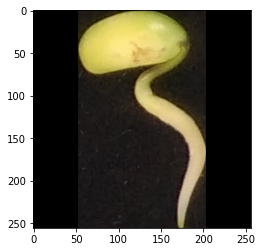

In [11]:
for i in range(len(images)):
    images[i] = pad_image(images[i], IMG_SIZE, IMG_SIZE)
    plt.imshow(images[i])

##### Labels one hot enconding

###### Train Test split

In [12]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

In [13]:
print(test_images.shape)

(221, 256, 256, 3)


#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [14]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [15]:
## Trying class weights
#it does not work withone hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

# from sklearn.utils import compute_sample_weight
# sample_weights = compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit


###### SMOTE

In [16]:
classes, counts = np.unique(train_labels, return_counts=True)
print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

The number of elements for each class in training now are
Class 0: 675
Class 1 176
Class 2 29



In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

train_images_shape = train_images.shape
train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [18]:
train_images_shape = train_images.shape
train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [19]:
classes, counts = np.unique(train_labels, return_counts=True)
print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

The number of elements for each class in training now are
Class 0: 675
Class 1 675
Class 2 675



##### One hot label encoding

In [20]:
import pandas as pd

train_labels = pd.get_dummies(train_labels)
train_labels = pd.DataFrame.to_numpy(train_labels)

test_labels = pd.get_dummies(test_labels)
test_labels = pd.DataFrame.to_numpy(test_labels)

##### Normalizing training images

In [21]:
# train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

### Creating the model


In [22]:
EPOCHS = 15
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 32
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

In [23]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier 
outputs = keras.layers.Dense(3, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

my_metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives(),]

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)



In [24]:
from keras.callbacks import ModelCheckpoint
METRICDIR = './metricas/classificacao/3_d/smote_transfer_learning/'
MODELDIR = os.path.join(METRICDIR, "model")
CHECKPOINT_DIR = os.path.join(MODELDIR, "best_checkpoint")
checkpoint = ModelCheckpoint(CHECKPOINT_DIR, monitor="val_precision", verbose=1,
    save_best_only=True, mode='max', save_freq='epoch')

In [25]:
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=TRAIN_TEST_SPLIT, callbacks=[checkpoint])

Epoch 1/15
48/48 [==============================] - 149s 3s/step - loss: 21.5756 - accuracy: 0.4480 - precision: 0.4548 - recall: 0.4691 - auc: 0.6393 - true_positives: 376.9592 - true_negatives: 1154.6735 - false_positives: 442.5510 - false_negatives: 421.6531 - val_loss: 59.5489 - val_accuracy: 0.0000e+00 - val_precision: 0.1916 - val_recall: 0.2525 - val_auc: 0.3230 - val_true_positives: 128.0000 - val_true_negatives: 474.0000 - val_false_positives: 540.0000 - val_false_negatives: 379.0000

Epoch 00001: val_precision improved from -inf to 0.19162, saving model to ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint
INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint/assets
Epoch 2/15
48/48 [==============================] - 132s 3s/step - loss: 16.6805 - accuracy: 0.4835 - precision: 0.4782 - recall: 0.5003 - auc: 0.6730 - true_positives: 398.3878 - true_negatives: 1159.5714 - false_positives: 437.6531 -

48/48 [==============================] - 124s 3s/step - loss: 2.5207 - accuracy: 0.6413 - precision: 0.4212 - recall: 0.9475 - auc: 0.6503 - true_positives: 760.4082 - true_negatives: 555.8980 - false_positives: 1041.3265 - false_negatives: 38.2041 - val_loss: 12.1657 - val_accuracy: 0.1657 - val_precision: 0.3184 - val_recall: 0.9132 - val_auc: 0.4552 - val_true_positives: 463.0000 - val_true_negatives: 23.0000 - val_false_positives: 991.0000 - val_false_negatives: 44.0000

Epoch 00012: val_precision improved from 0.31702 to 0.31843, saving model to ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint
INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint/assets
Epoch 13/15
48/48 [==============================] - 125s 3s/step - loss: 2.6018 - accuracy: 0.6394 - precision: 0.4243 - recall: 0.9481 - auc: 0.6519 - true_positives: 760.2857 - true_negatives: 557.0408 - false_positives: 1040.1837 - false_negatives

##### Loading the best model for testing

In [26]:
model = keras.models.load_model(CHECKPOINT_DIR)

##### Testing the model

In [27]:
model.evaluate(test_images, test_labels, batch_size=1)

221/221 [==============================] - 18s 77ms/step - loss: 2.0694 - accuracy: 0.6968 - precision: 0.5073 - recall: 0.9412 - auc: 0.7403 - true_positives: 208.0000 - true_negatives: 240.0000 - false_positives: 202.0000 - false_negatives: 13.0000


[2.0693724155426025,
 0.6968325972557068,
 0.507317066192627,
 0.9411764740943909,
 0.74032062292099,
 208.0,
 240.0,
 202.0,
 13.0]

#### Visualizing model data

In [28]:
import matplotlib.pyplot as plt

In [29]:
NUM_METRICS = len(my_metrics) + 1

SAVE = True

def plot_metric(metric_name, chart_name):
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if SAVE and not os.path.exists(METRICDIR):
        os.mkdir(METRICDIR)
    if SAVE:
        plt.savefig(os.path.join(METRICDIR, metric_name))
    plt.show()


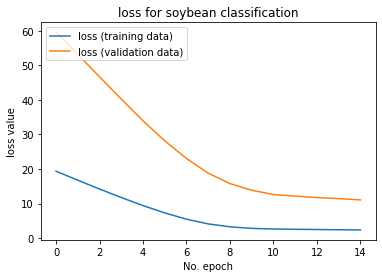

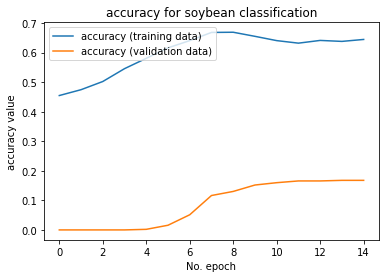

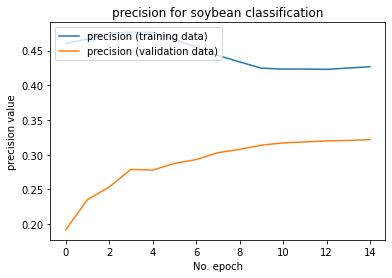

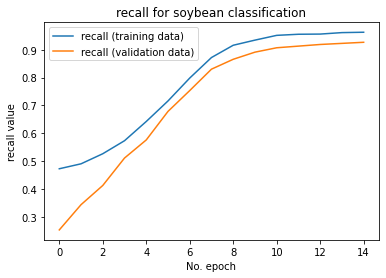

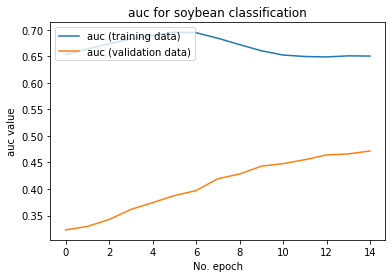

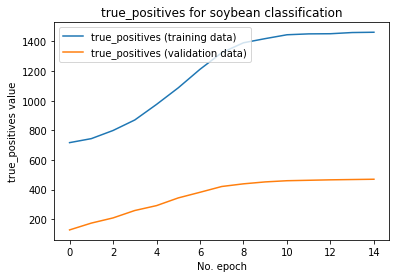

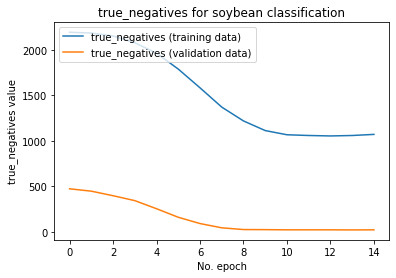

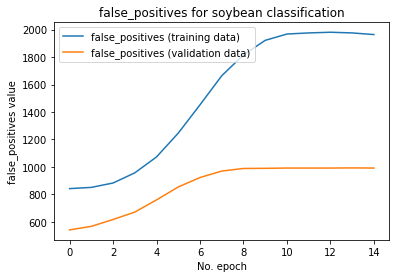

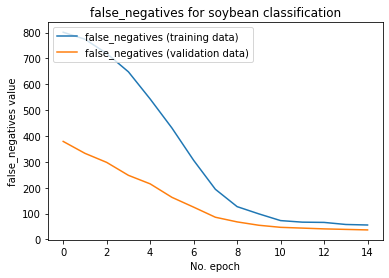

In [30]:
for metric in list(history.history.keys())[:NUM_METRICS]:
    plot_metric(metric, metric + " for soybean classification")
